# Classification trees
This lab is a level up from previous sessions ! There is no code snippet for demonstration, as you should now be able to answer the different questions by reading the documentation.

In [32]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [33]:
# My target is shot_made_flag 

df = pd.read_csv("../Datasets/kobe.csv")
data_process = df.dropna().reset_index()

minutes = data_process["minutes_remaining"].values
secondes = data_process["seconds_remaining"].values
temps_restant = pd.Series((minutes*60 + secondes), name="temps_restant")

qualitative_vars = ["action_type", "combined_shot_type", "game_event_id", "game_id", "period", "playoffs", "season", "shot_type", "shot_zone_area", "shot_zone_basic", "shot_zone_range", "team_name", "game_date", "matchup", "opponent"]
quantitative_vars = [col for col in data_process.columns if col not in qualitative_vars + ["shot_made_flag", "shot_id", 'team_id', "minutes_remaining", "seconds_remaining"]]  # garder le shot_id ?

data_process = data_process.drop(columns=["minutes_remaining","seconds_remaining"], axis=1)
print(data_process.columns)
quantitative_vars.append("temps_restant")
data = pd.concat([data_process, temps_restant], axis=1)
X = data[qualitative_vars + quantitative_vars].values
X_quantitative = data[quantitative_vars].values
X_categorical = data[qualitative_vars].values
y = data_process["shot_made_flag"].values

feature_names = quantitative_vars + qualitative_vars

Index(['index', 'action_type', 'combined_shot_type', 'game_event_id',
       'game_id', 'lat', 'loc_x', 'loc_y', 'lon', 'period', 'playoffs',
       'season', 'shot_distance', 'shot_made_flag', 'shot_type',
       'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'team_id',
       'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')


In [34]:
X_preprocess = X_quantitative
for feature in qualitative_vars:
    label_encoder = LabelEncoder()
    X_cat_label = label_encoder.fit_transform(data[feature].values)
    X_preprocess = np.concatenate([X_preprocess, X_cat_label.reshape(25697,1)], axis=1)

## Classification trees

### Building a tree

**Questions**:
1. Build a decision tree on your previously processed dataset, using `DecisionTreeClassifier` (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).
2. What are the different available hyperparameters in sklearn for decision trees ?
3. Select optimum hyperparameters using a cross validation setting.
4. Return optimum parameters combination using cross validation and final accuracy (or recall or precision depending on your wanted target)
5. Explain how the attribute `feature_importances_` is computed.
6. Plot an elbow plot the most important features in your dataset and select the subset of most important features.
7. Run classification experiment and see if results are impacted.
8. **Bonus**: Use the features selected by the trees and test the two other classification method we tested: KNN and Naive Bayes.

#Question 1 

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocess, y,test_size=0.2, random_state=0)

decision_tree_classifier = DecisionTreeClassifier()

grid_search_cv = GridSearchCV(estimator=decision_tree_classifier,
                              param_grid={"criterion": ["gini", "entropy", "log_loss"],
                                         "max_features": range(1, 10, 1),
                                         "max_depth": range(1, 10, 1)})
grid_search_cv.fit(X_preprocess, y)
print(f"Best score: {grid_search_cv.best_score_}")
print(f"For parameters: {grid_search_cv.best_params_}")
best_params = grid_search_cv.best_params_

# Fit and test tree using best params
decision_tree = DecisionTreeClassifier(**best_params)
decision_tree.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)
predictions = decision_tree.predict(X_test)
print(classification_report(y_test, predictions))

Best score: 0.6653288539686216
For parameters: {'criterion': 'log_loss', 'max_depth': 3, 'max_features': 9}
              precision    recall  f1-score   support

         0.0       0.60      0.97      0.74      2866
         1.0       0.82      0.20      0.32      2274

    accuracy                           0.63      5140
   macro avg       0.71      0.58      0.53      5140
weighted avg       0.70      0.63      0.56      5140



Les variables les plus importantes pour la prise de décisions sont ['loc_y', 'action_type', 'combined_shot_type', 'shot_type']


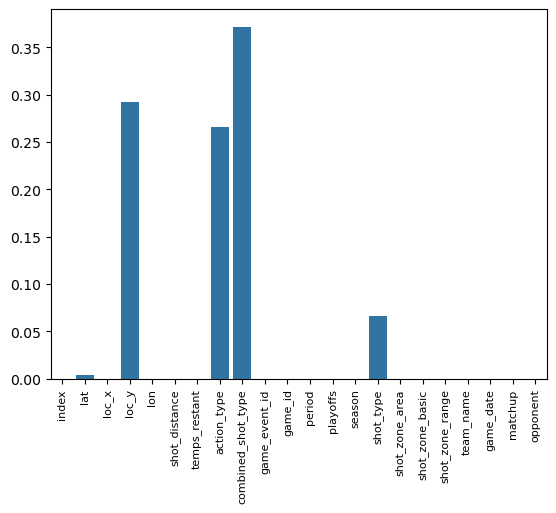

In [58]:
g = sns.barplot(x=list(range(len(decision_tree.feature_importances_))),
            y=decision_tree.feature_importances_)

g.set_xticks(range(len(feature_names)))
g.set_xticklabels(feature_names, rotation=90, fontsize=8)

important_feature_names = [feature_names[i] for i, importance in enumerate(decision_tree.feature_importances_) if importance > 0.02]
print(f"Les variables les plus importantes pour la prise de décisions sont {important_feature_names}")

mask = decision_tree.feature_importances_>0.02
sub_X_preprocess = X_preprocess[:,mask]
X_train, X_test, y_train, y_test = train_test_split(sub_X_preprocess, y,test_size=0.2, random_state=0)

In [46]:
grid_search_cv = GridSearchCV(estimator=decision_tree_classifier,
                              param_grid={"criterion": ["gini", "entropy", 'log_loss'],
                                         "max_features": range(1, 10, 1),
                                         "max_depth": range(1, 10, 1)})
grid_search_cv.fit(sub_X_preprocess, y)
print(f"Best score: {grid_search_cv.best_score_}")
print(f"For parameters: {grid_search_cv.best_params_}")
best_params = grid_search_cv.best_params_

# Fit tree using best params
decision_tree_optimized = DecisionTreeClassifier(**best_params)
decision_tree_optimized.fit(X_train, y_train)
predictions = decision_tree_optimized.predict(X_test)
print(classification_report(y_test, predictions))

Best score: 0.6790668671629099
For parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 2}
              precision    recall  f1-score   support

         0.0       0.66      0.85      0.75      2866
         1.0       0.71      0.46      0.56      2274

    accuracy                           0.68      5140
   macro avg       0.69      0.65      0.65      5140
weighted avg       0.68      0.68      0.66      5140



In [39]:
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)
print(f"== Working with accuracy")
scores = cross_val_score(estimator=decision_tree_classifier, X=sub_X_preprocess, y=y, cv=cv)
print(f"Mean accuracy: {np.mean(scores)}")
print(f"Median accuracy: {np.median(scores)}")

== Working with accuracy
Mean accuracy: 0.5765263495827664
Median accuracy: 0.5784046692607004


### Representation

Trees can be represented using the `tree.plot_tree` function.

In [40]:
feature_names

['index',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'shot_distance',
 'temps_restant',
 'action_type',
 'combined_shot_type',
 'game_event_id',
 'game_id',
 'period',
 'playoffs',
 'season',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'team_name',
 'game_date',
 'matchup',
 'opponent']

[Text(0.5, 0.8333333333333334, 'x[4] <= -118.302\nentropy = 0.992\nsamples = 25697\nvalue = [14232, 11465]'),
 Text(0.25, 0.5, 'x[5] <= 25.5\nentropy = 0.959\nsamples = 7723\nvalue = [4776, 2947]'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.968\nsamples = 6851\nvalue = [4142, 2709]'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.846\nsamples = 872\nvalue = [634, 238]'),
 Text(0.75, 0.5, 'x[4] <= -118.256\nentropy = 0.998\nsamples = 17974\nvalue = [9456, 8518]'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.985\nsamples = 7707\nvalue = [3292, 4415]'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.971\nsamples = 10267\nvalue = [6164, 4103]')]

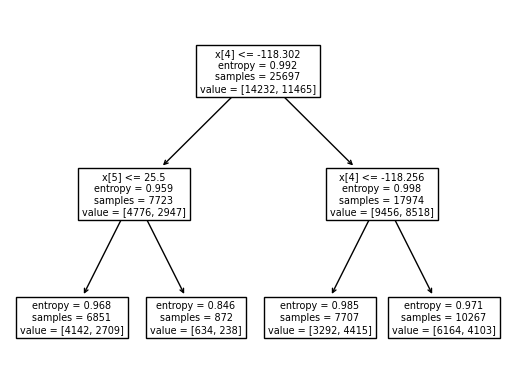

In [41]:
# Create classifier with the best found hyperparameters
best_params["max_depth"] = 2
decision_tree = DecisionTreeClassifier(**best_params)
decision_tree.fit(X_preprocess, y)
plot_tree(decision_tree)

In [42]:
best_params

{'criterion': 'entropy', 'max_depth': 2, 'max_features': 3}

**Questions**:
1. Plot the previous tree.
2. Explain every single information provided by the tree.

## Random forests
One of the major drawbacks of decision trees is their tendency to severely overfit on the data given as input. To improve this behavior, multiples trees are often built on randomly drawn subset of individuals and their contribution to the classification voted.

**Questions**:
1. Build a random forest using the class`RandomForestClassifier` https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.
2. Identify the hyperparameters and select the optimum combination using cross validation.
3. Train the random forest on the whole dataset and return the final score.
4. **Bonus**: compare the resilience to over fitting of trees and random forests by performing the following experiments: split the dataset into train and test, compare the results of the trees on train and test with the results of the random forest on the same dataset.

In [43]:
random_forest = RandomForestClassifier()

grid_search_cv = GridSearchCV(estimator=random_forest,
                              param_grid={"n_estimators": range(1, 10, 5),
                                           "criterion": ["gini", "entropy"],
                                           "max_depth" : range(1,20,1)})
grid_search_cv.fit(sub_X_preprocess, y)

print(f"Best score: {grid_search_cv.best_score_}")
print(f"For parameters: {grid_search_cv.best_params_}")
best_params = grid_search_cv.best_params_

# Fit tree using best params
random_forest = RandomForestClassifier(**best_params)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)
print(classification_report(y_test, predictions))

Best score: 0.6788723752066103
For parameters: {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 6}
              precision    recall  f1-score   support

         0.0       0.66      0.85      0.74      2866
         1.0       0.71      0.44      0.55      2274

    accuracy                           0.67      5140
   macro avg       0.68      0.65      0.64      5140
weighted avg       0.68      0.67      0.66      5140



In [44]:
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)
print(f"== Working with accuracy")
scores = cross_val_score(estimator=random_forest, X=sub_X_preprocess, y=y, cv=cv)
print(f"Mean accuracy: {np.mean(scores)}")
print(f"Median accuracy: {np.median(scores)}")

== Working with accuracy
Mean accuracy: 0.6780168210896608
Median accuracy: 0.6768482490272374


In [45]:
random_forest = RandomForestClassifier(**best_params)

random_forest.fit(sub_X_preprocess, y)

print(f"Final score: {random_forest.score(sub_X_preprocess, y)}")

Final score: 0.6828034400902829
